# SISPS-AST9AH-EIS

Main root file for analysis of SISPS-AST9AH-EIS experiment.

[Lawrence Stanton](mailto:lawrence.stanton@uct.ac.za)

- _Began_ March 2024
- _Revised_ June 2024


## Environment

The required environment is described in the '[environment.yml](environment.yml)' file. To create the environment, run the following command (or equivalent for your IDE):

```bash
conda env create -f environment.yml
```

```{note}
Last tested using Python 3.11
```


In [1]:
import time

# Begin timer
startTime = time.time()

In [2]:
from  matplotlib import pyplot as plt

# Modify default plotting style
plt.style.use('dark_background')  # <--- comment toggle per visual preference

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (8, 5)
%config InlineBackend.figure_formats = ['svg']

nyquistRealAxisLabel = 'Real Impedance (mΩ)'
nyquistImagAxisLabel = 'Imaginary Impedance (mΩ)'




## Electrochemical Impedance Spectroscopy (EIS) Data Import

Importing raw data from the EIS experiment, and converting it into a format that can be used for analysis.

A subset of files are final test data files, filtered manually during the experiment. All other test files are collected under `All` (including duplicates of final test files). These may be run for some basic analysis but not all.

In [3]:
from eisImport import findMainEisFiles, findAllEisFiles, readEisFiles

eisDirectory = "../Data/EIS"
eisFiles = findMainEisFiles(eisDirectory)
eisRaw = readEisFiles(tuple(eisFiles))

eisAllFiles = findAllEisFiles(eisDirectory)
eisRawAll = readEisFiles(tuple(eisAllFiles))

Also import manual measurements and observations, importantly including temperature measurements.

In [4]:
from eisImport import (
    readMeasurementsAndObservations,
    groupMeasurementsAndObservations,
    inferObservationTestNames,
)

observationsFile = "../Data/UCT AST9AH Measurements and Observations.xlsx"
eisObservations = groupMeasurementsAndObservations(
    readMeasurementsAndObservations(observationsFile)
)
inferObservationTestNames(eisObservations)

Plots for visual check on temperature ranges.

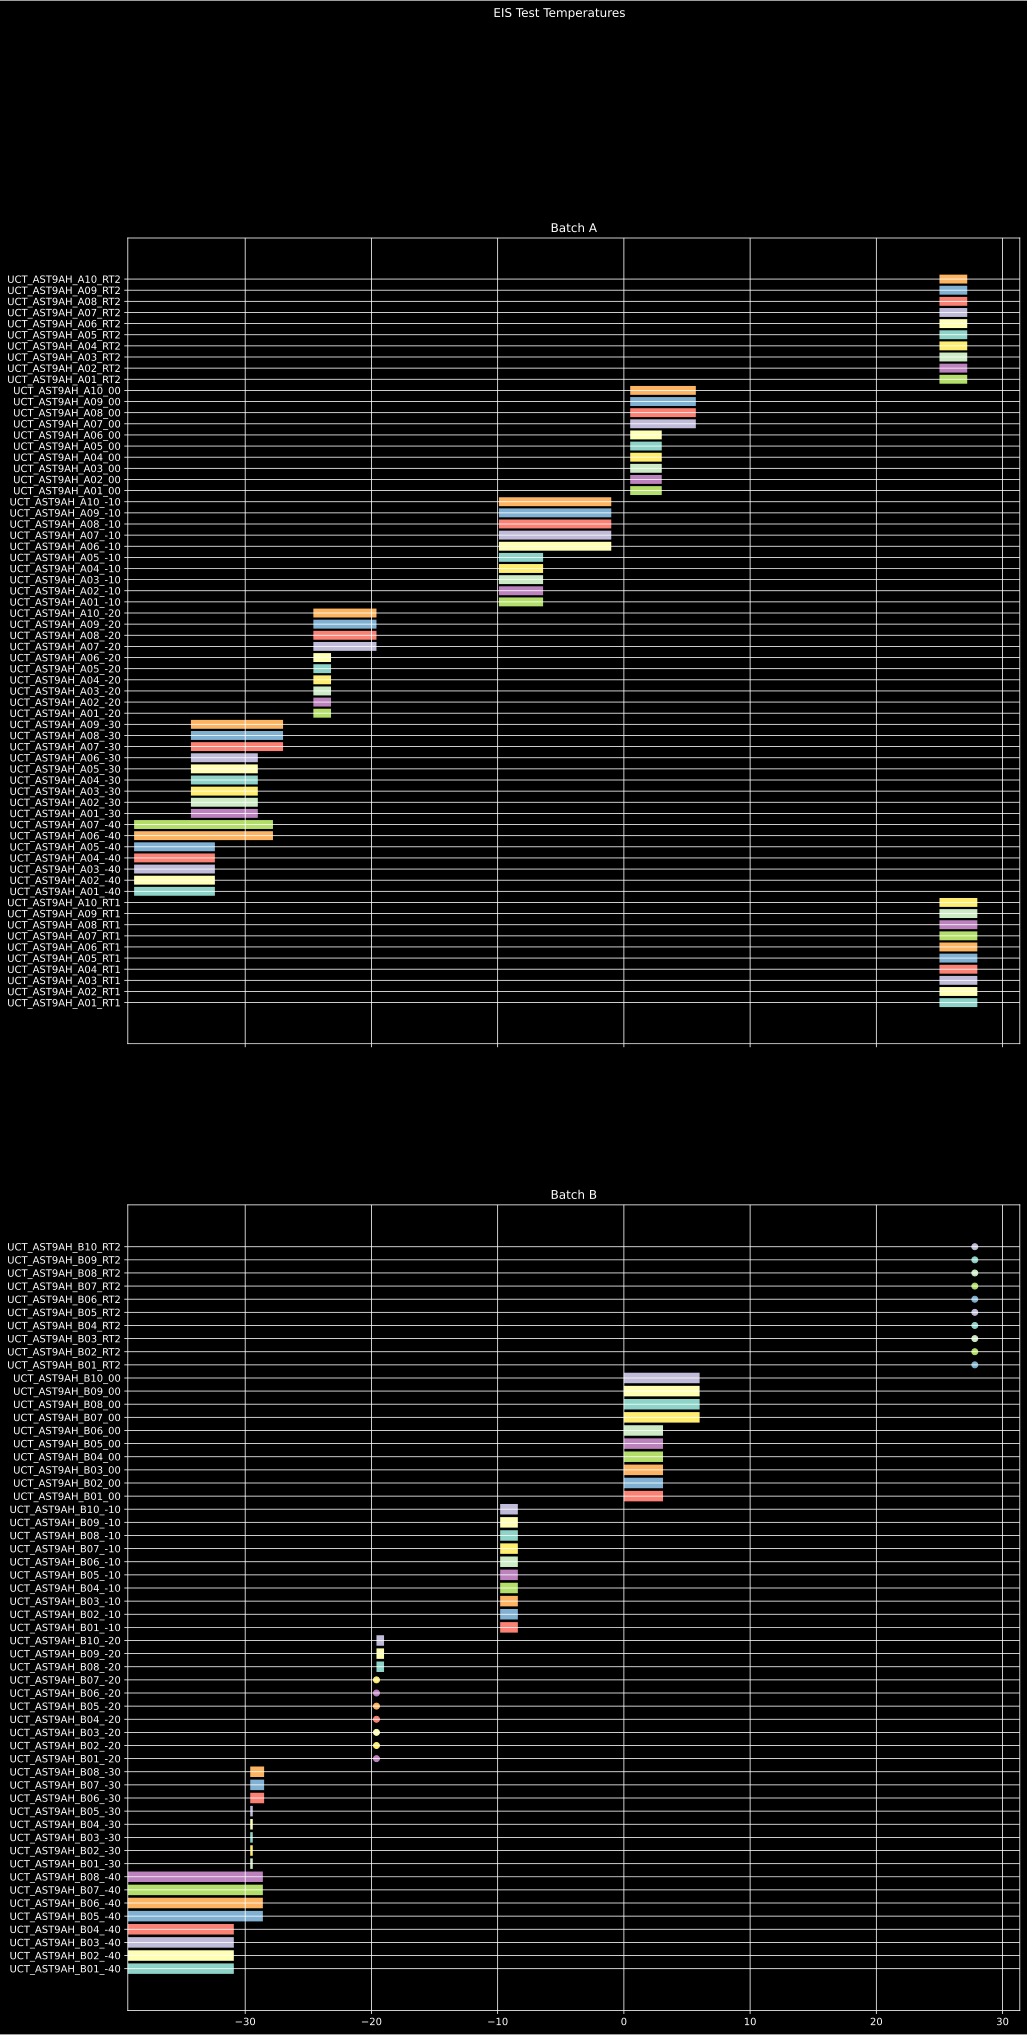

In [5]:
from eisPlot import plotEisTestTemperatureRanges


temperatureRangeFig = plotEisTestTemperatureRanges(
    eisObservations,
    "../Plots/Temperature",
    "EIS_Temperature_Ranges.svg",
)

### Raw EIS Plots

Plots all EIS spectra individually. This is useful for visual inspection of the raw data.

Plots are saved under the `Plots` directory and are only generated once based on the existence of the target directories (which are not committed to the repository ala `.gitignore`). To regenerate the plots, delete the `Plots` directory and rerun this cell.

Overlaid plot of all tests is also generated for a quick visual comparison of all tests and reference against preprocessing.

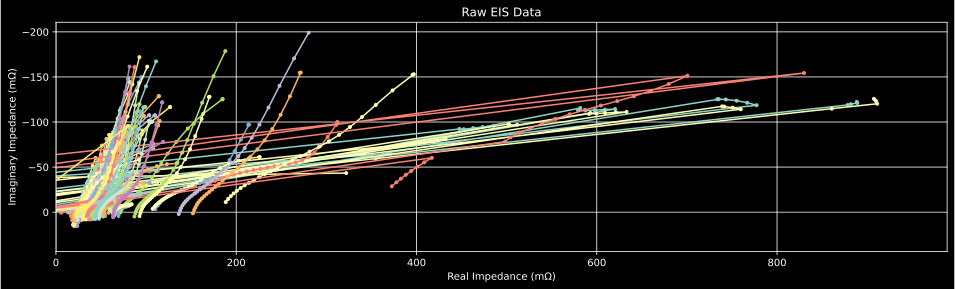

In [6]:
from eisPlot import plotNyquist, plotIndividualNyquist

individualRawEisPlotConfig = [
    {
        "eisData": eisRaw,
        "saveDir": "../Plots/EIS/Raw/Main",
        "scatter": False,
    },
    {
        "eisData": eisRawAll,
        "saveDir": "../Plots/EIS/Raw/All",
        "scatter": False,
    },
]

for config in individualRawEisPlotConfig:
    plotIndividualNyquist(**config)
plt.close("all")

rawEisPlotFigure = plotNyquist(
    eisRaw,
    title="Raw EIS Data",
)
plt.legend().remove()

### Preprocessing

#### Erroneous Point Removal

Some plots contain points that are clearly erroneous and were tolerated due to the experiment time and temperature control constraints. In general, only single outliers in sequence are accepted (although there are some exceptions to this). This preprocessing step removes these points.

2 main erroneous modes were identified:

1. **50/100Hz Noise Issues**  
   Some spectra have outlying points at near 50Hz and 100Hz frequencies. This is likely due to an issue in the power supply (for which significant electronic effort in the Digatron design was made to mitigate). Without changing measurement channels (which would introduce other offsets), these points were tolerated.
2. **DSP Garbage In / Garbage Out**  
   Some batteries may have produced response signals that were not properly filtered or otherwise accepted by the Digatron DSP pipeline when computing impedance values. Often these are obvious due to negative real impedance values (which are impossible in reality).

The preprocessing step removes these points. Details of the removal are documented in the responsible functions.


Filtered 4 negative real points from UCT_AST_A10_-20 RUN 2
Filtered 6 negative real points from UCT_AST_A10_-20 RUN 1
Filtered 3 negative real points from UCT_AST_B10_-20
Filtered 1 negative real points from UCT_AST_B09_+00
Filtered 1 negative real points from UCT_AST_B07_+RT2
Filtered 2 negative real points from UCT_AST_B05_+RT2
Filtered 1 negative real points from UCT_AST_B05_-40 3


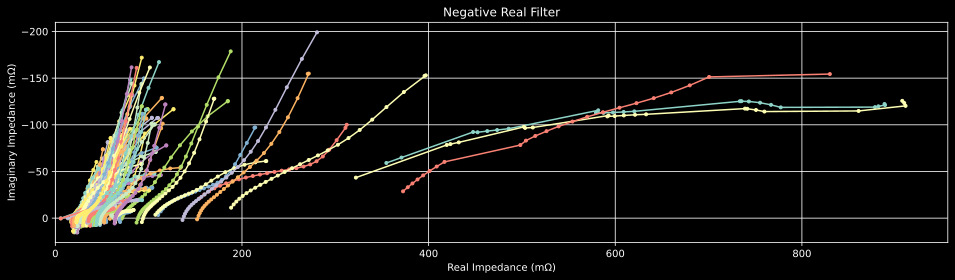

In [7]:
from eisPreprocess import filterNegativeReal

eisNegRealProcessed = filterNegativeReal(eisRaw)

plotIndividualNyquist(
    eisNegRealProcessed,
    "../Plots/EIS/Processed/NegRealFilter/Main",
    False,
)
plt.close('all')

plotNyquist(
    eisNegRealProcessed,
    title="Negative Real Filter",
)
plt.legend().set_visible(False)
plt.show()

In [8]:
from eisPlot import plotNyquistComparison, EisDataComparison
from eisPreprocess import filterSingleOutlier


(eisSingleOutlierProcessed, singleOutlierModifiedSpectra) = filterSingleOutlier(
    eisNegRealProcessed
)

for spectra in singleOutlierModifiedSpectra:
    eisDataComparison = EisDataComparison(
        {
            "eis1": {
                "name": f"Pre-filter",
                "value": eisNegRealProcessed[spectra],
            },
            "eis2": {
                "name": f"Post-filter",
                "value": eisSingleOutlierProcessed[spectra],
            },
        }
    )

    plotNyquistComparison(
        eis1=eisDataComparison["eis1"],
        eis2=eisDataComparison["eis2"],
        mainTitle=f"Single Outlier Filter Comparison: {spectra}",
        figsize=(16, 9),
    ).show()


plotIndividualNyquist(
    eisSingleOutlierProcessed,
    "../Plots/EIS/Processed/SingleOutlierFilter/Main",
    False,
)
plt.close("all")

Filtered 1 outliers from UCT_AST_B07_-10 at frequencies [53.333]Hz
Filtered 1 outliers from UCT_AST_B05_-20 at frequencies [94.862]Hz
Filtered 1 outliers from UCT_AST_B09_+00 at frequencies [71.217]Hz


/var/folders/3f/ct0r54cd0497vnq7h8jk96q40000gp/T/ipykernel_6928/1459563368.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/3f/ct0r54cd0497vnq7h8jk96q40000gp/T/ipykernel_6928/1459563368.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()
/var/folders/3f/ct0r54cd0497vnq7h8jk96q40000gp/T/ipykernel_6928/1459563368.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()


### Renaming

While there was an attempt to standardize the naming of the files, there are still some inconsistencies. This step renames the files to a consistent format, given sufficient matching information in the current input.

Additionally, the dictionary is sorted by key name.


In [9]:
from eisPreprocess import renameLabels

eisRenamed = renameLabels(eisSingleOutlierProcessed)
eisRenamed = dict(sorted(eisRenamed.items()))

Rename: ➤ UCT_AST_9AH_A08_+RT       ➤ UCT_AST9AH_A08_RT1
Rename: ➤ UCT_AST_9AH_A05_+RT       ➤ UCT_AST9AH_A05_RT1
Rename: ➤ UCT_AST_9AH_A02_+RT       ➤ UCT_AST9AH_A02_RT1
Rename: ➤ UCT_AST_9AH_A07_+RT       ➤ UCT_AST9AH_A07_RT1
Rename: ➤ UCT_AST_9AH_A04_+RT       ➤ UCT_AST9AH_A04_RT1
Rename: ➤ UCT_AST_9AH_A03_+RT1      ➤ UCT_AST9AH_A03_RT1
Rename: ➤ UCT_AST_9AH_A09_+RT       ➤ UCT_AST9AH_A09_RT1
Rename: ➤ UCT_AST_9AH_A10_+RT       ➤ UCT_AST9AH_A10_RT1
Rename: ➤ UCT_AST_9AH_A06_+RT       ➤ UCT_AST9AH_A06_RT1
Rename: ➤ UCT_AST_9AH_A01_+RT       ➤ UCT_AST9AH_A01_RT1
Rename: ➤ UCT_AST_A04_-10           ➤ UCT_AST9AH_A04_-10
Rename: ➤ UCT_AST_A05_-10           ➤ UCT_AST9AH_A05_-10
Rename: ➤ UCT_AST_A10_-10           ➤ UCT_AST9AH_A10_-10
Rename: ➤ UCT_AST_A07_-10           ➤ UCT_AST9AH_A07_-10
Rename: ➤ UCT_AST_A06_-10           ➤ UCT_AST9AH_A06_-10
Rename: ➤ UCT_AST_A03_-10           ➤ UCT_AST9AH_A03_-10
Rename: ➤ UCT_AST_A08_-10           ➤ UCT_AST9AH_A08_-10
Rename: ➤ UCT_AST_A09_-10      

#### Validation

Final check to confirm all data present and accounted for. This is a simple check to ensure that all files have been processed and renamed correctly.

In [10]:
# Rename variable before moving forward
eis = eisRenamed

### Analysis

This section contains general analysis of the EIS data, including:

- **Constant Temperature, Varied SoC**  
  Analysis of the impedance spectra at a constant temperature and varied state of charge.
- **Constant SoC, Varied Temperature**  
  Analysis of the impedance spectra at a constant state of charge and varied temperature.
- **Batch A Before-After Room Temperature**  
  Analysis of the impedance spectra for Batch A before and after room temperature cycling.
- **Batch A vs Batch B Comparisons**  
  Analysis of the impedance spectra for Batch A and Batch B at the same state of charge and temperature.


#### Constant SoC, Varied Temp

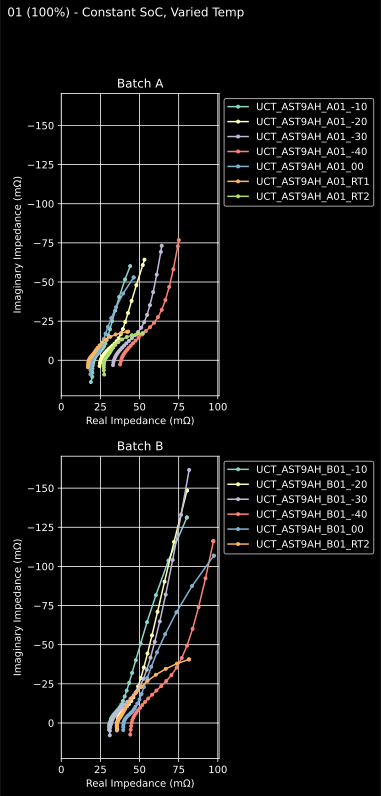

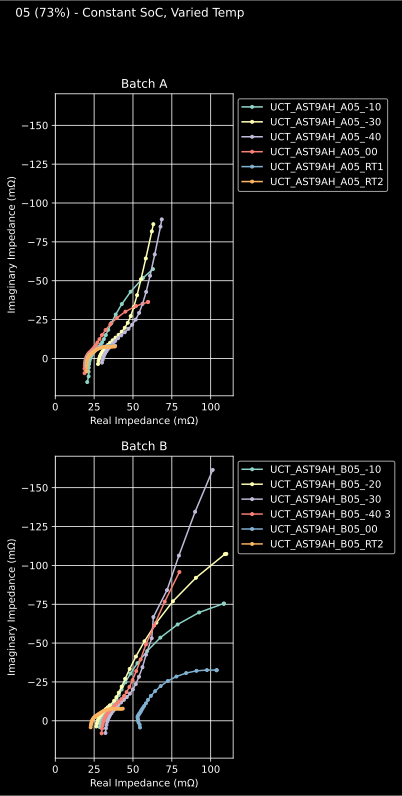

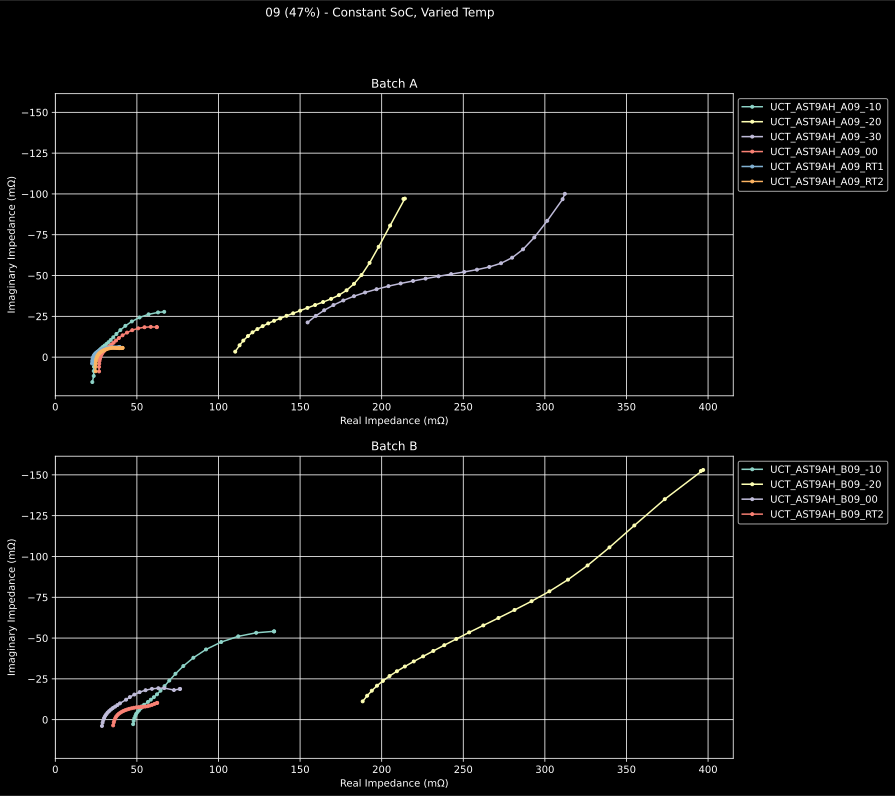

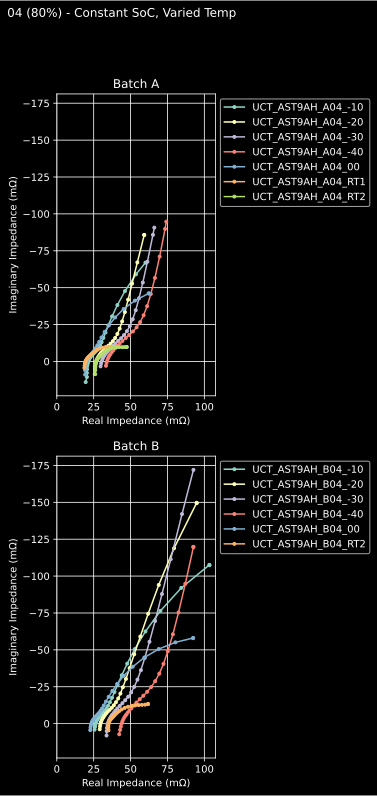

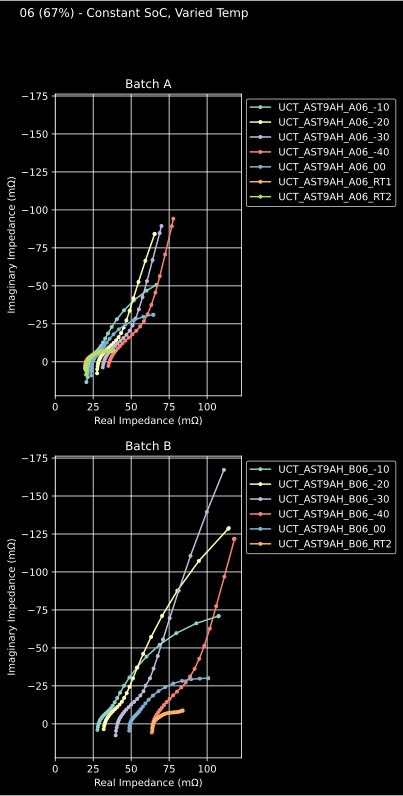

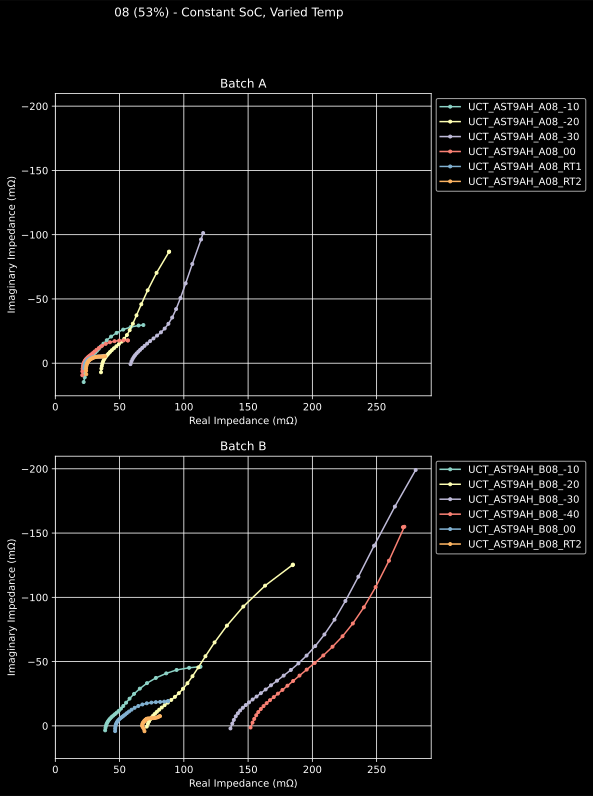

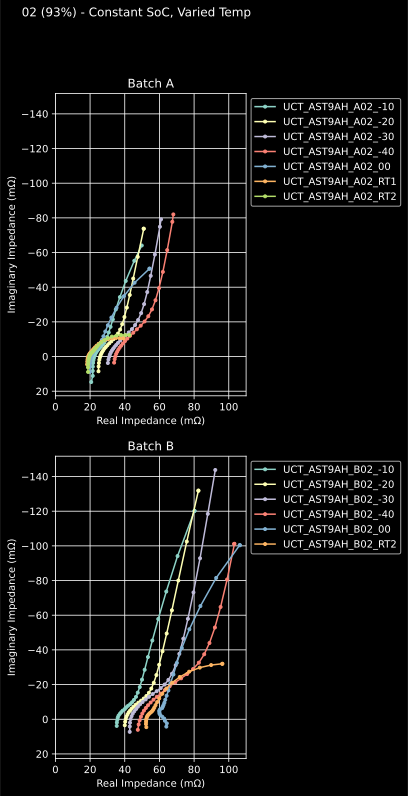

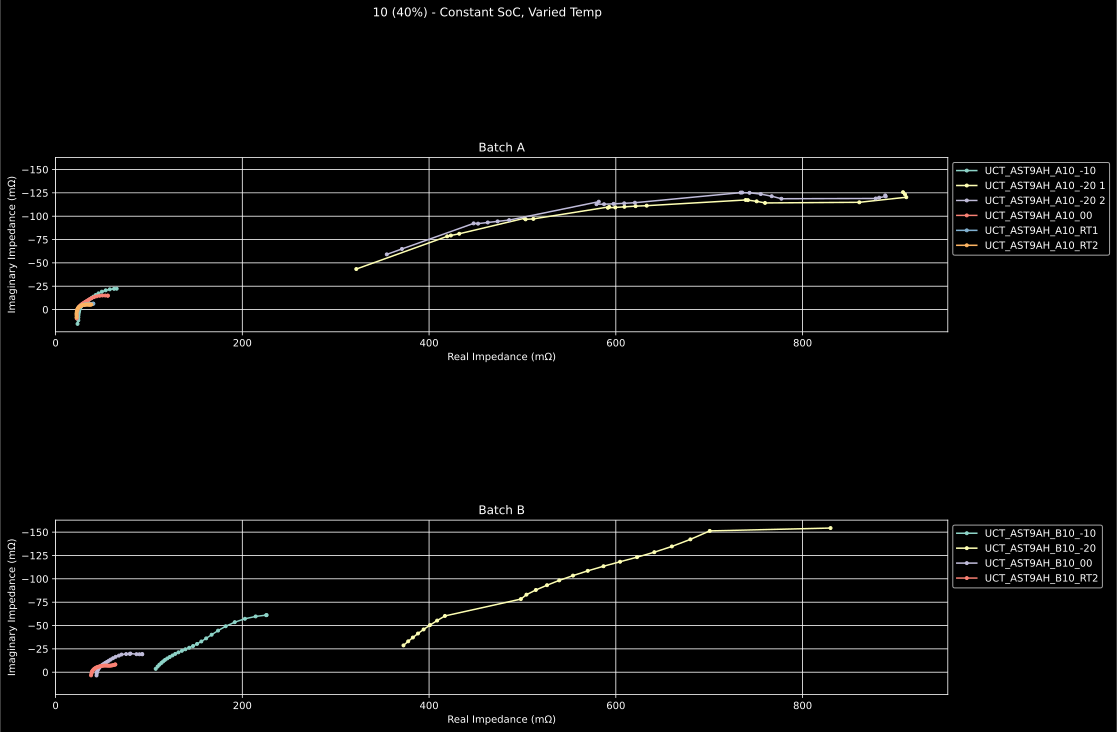

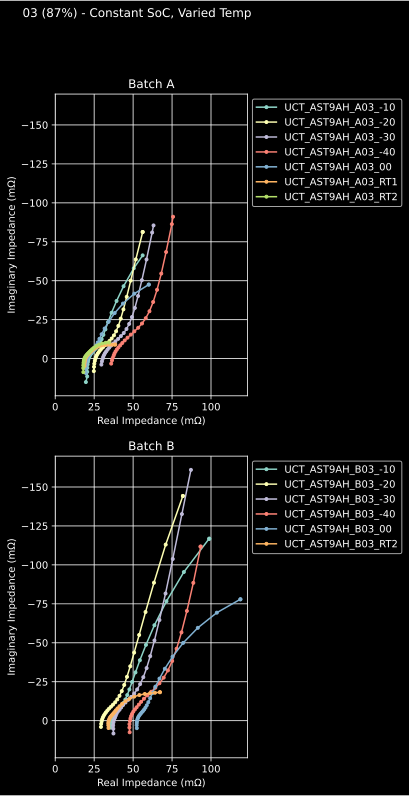

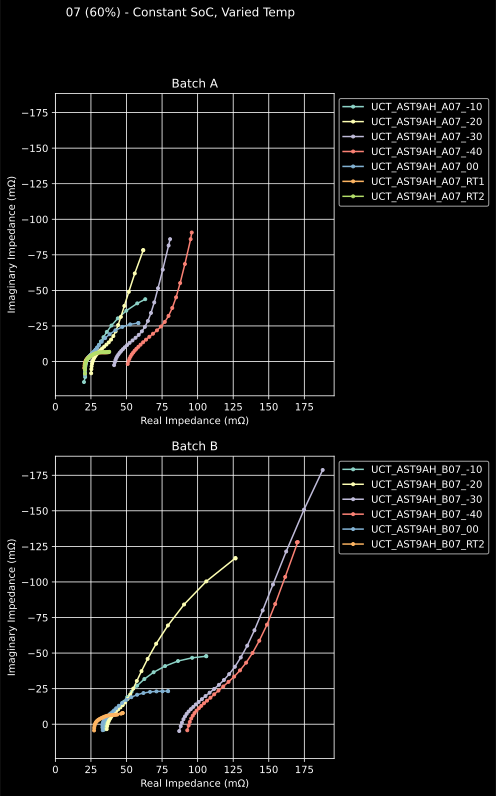

In [11]:
import os
from concurrent import futures

from matplotlib.figure import Figure
from typing import Dict

from eisAnalysis import splitByBatteryNumber, splitByBatch, getSoC
from eisImport import EisData

eisByBattery = splitByBatteryNumber(eis)


def plotConstSoCVariedTempNyquistBatchComparison(
    eisByBattery: Dict[str, Dict[str, EisData]],
    battery: str,
    saveDir: str,
) -> Figure | None:
    soc = getSoC(list(eisByBattery[battery].keys())[0])

    batchSplit = splitByBatch(eisByBattery[battery])

    fig, ax = plt.subplots(2, 1, figsize=(18, 24), sharey=True)

    fig.suptitle(
        f"{battery} ({soc}) - Constant SoC, Varied Temp",
        horizontalalignment="center",
    )

    for batch in batchSplit:
        plotNyquist(
            batchSplit[batch],
            title=f"Batch {batch}",
            ax=ax[0] if batch == "A" else ax[1],
        )

    ax[0].legend(loc="upper left", bbox_to_anchor=(1, 1))
    ax[1].legend(loc="upper left", bbox_to_anchor=(1, 1))

    ax[0].invert_yaxis()  # Shared y-axis nulled double inversion in plotNyquist
    (
        ax[0].set_xlim(ax[1].get_xlim())
        if ax[0].get_xlim() < ax[1].get_xlim()
        else ax[1].set_xlim(ax[0].get_xlim())
    )

    fig.savefig(
        f"{saveDir}/{battery}.png",
        transparent=True,
    )

    return fig


saveDir = "../Plots/EIS/Analysis/ConstSoCVariedTemp"
os.makedirs(saveDir, exist_ok=True)
with futures.ThreadPoolExecutor() as executor:
    for battery in eisByBattery:
        executor.submit(
            plotConstSoCVariedTempNyquistBatchComparison,
            eisByBattery,
            battery,
            saveDir,
        )

### Constant Temperature, Varied SoC

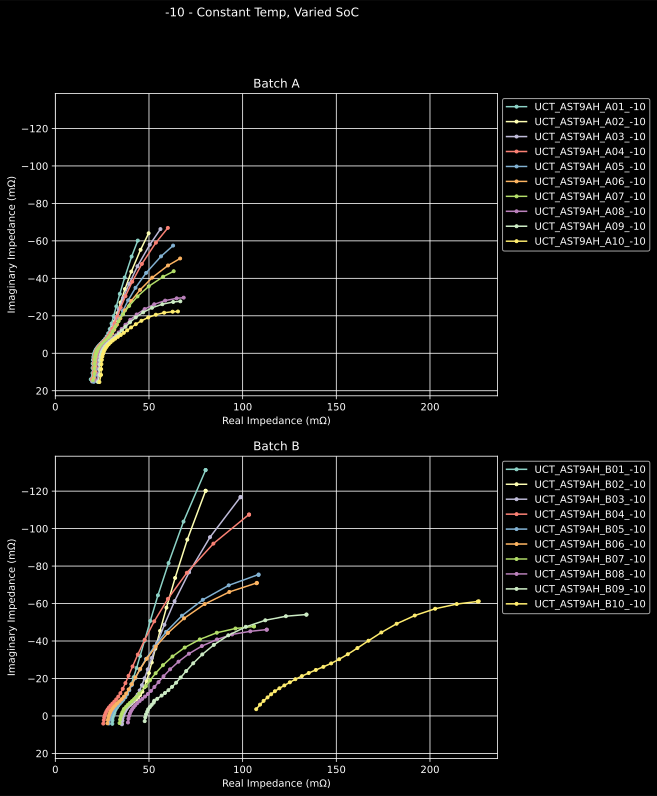

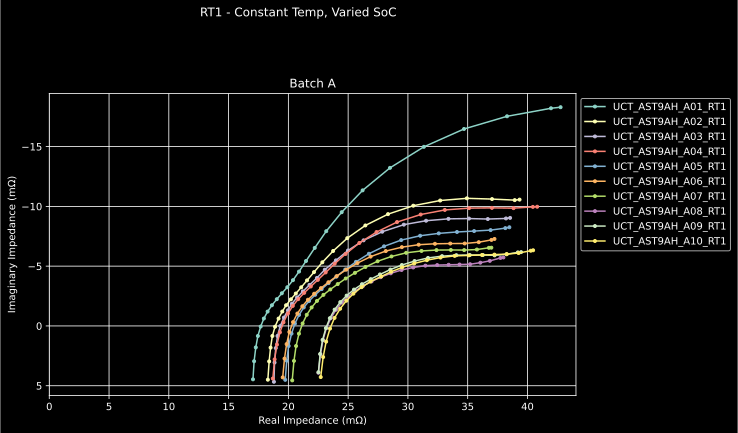

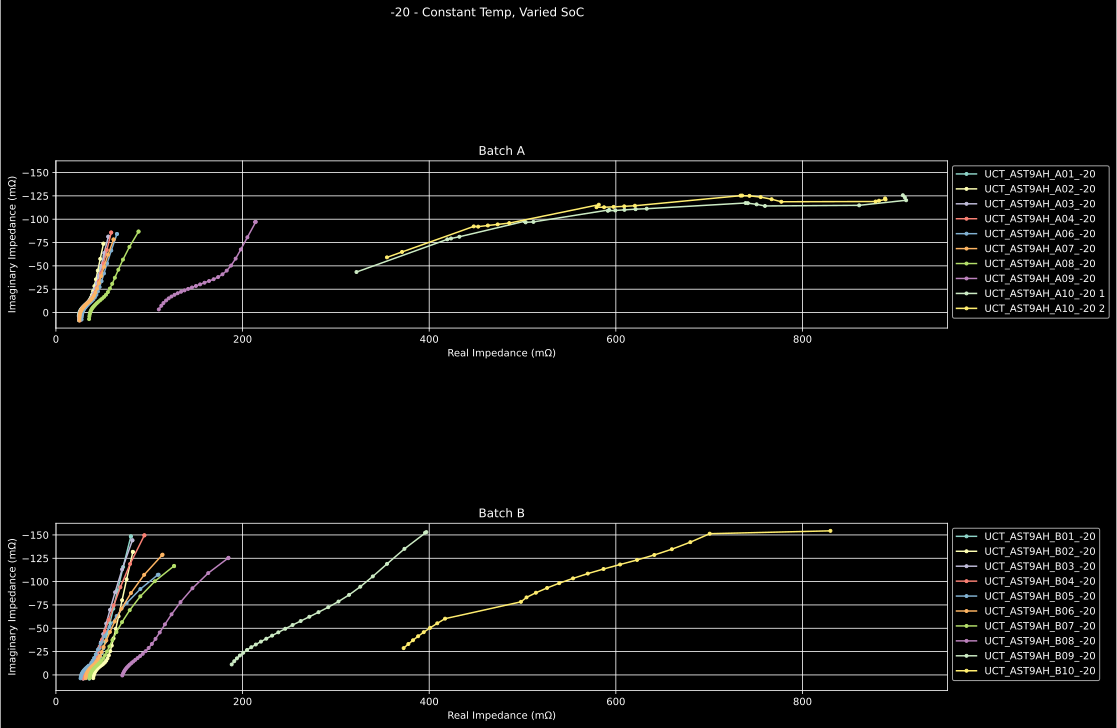

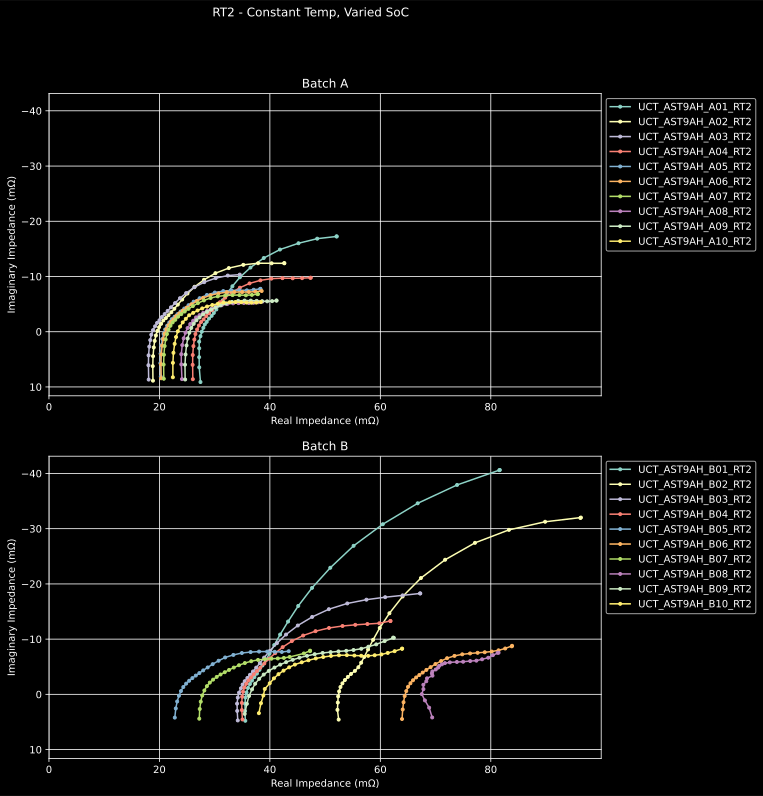

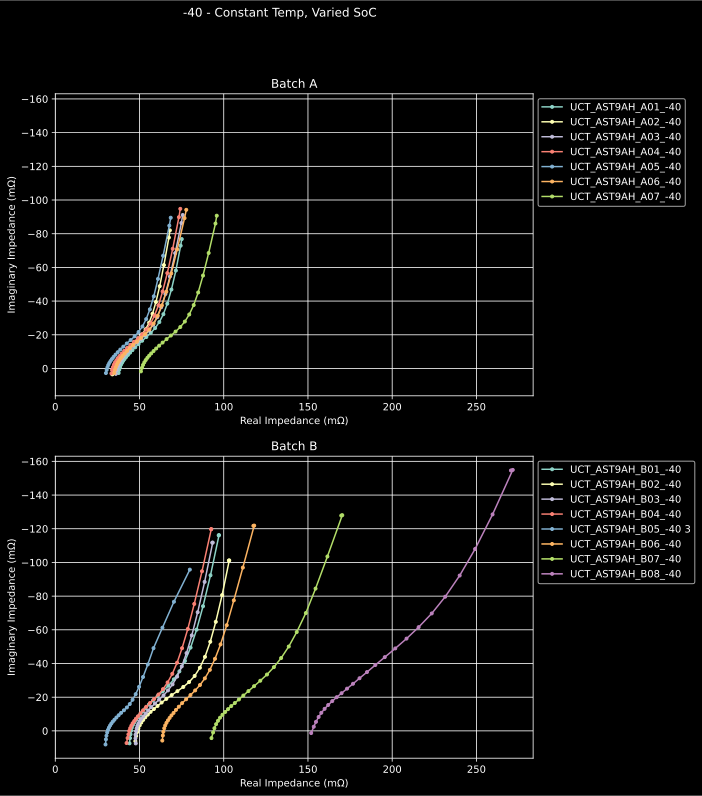

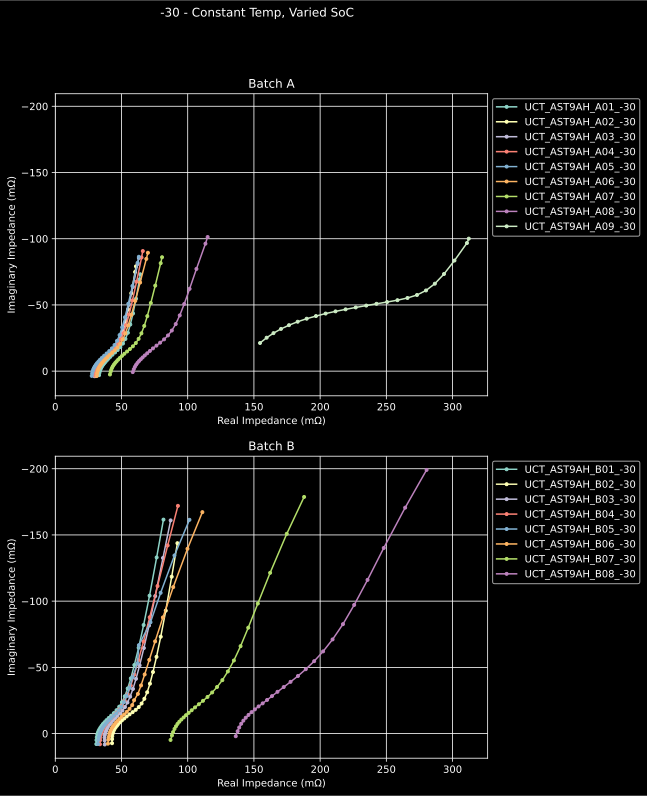

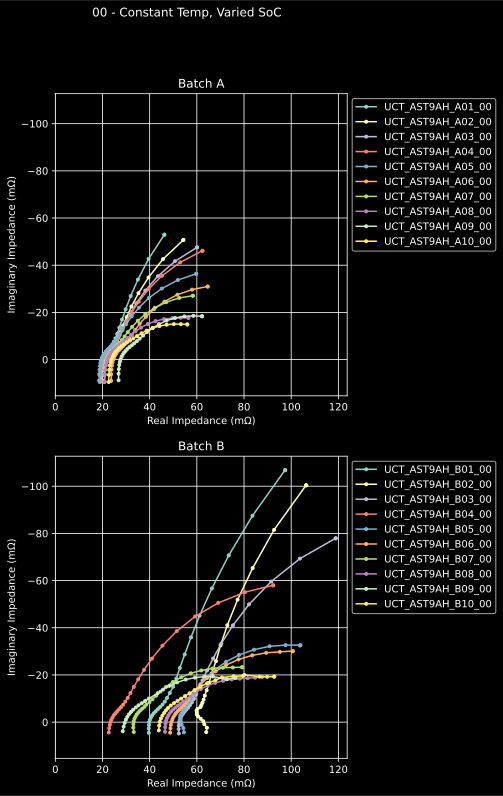

In [12]:
from eisAnalysis import splitByTemperature

eisByTemp = splitByTemperature(eis)


def plotConstTempVariedSocNyquistBatchComparison(
    eisByTemp: Dict[str, Dict[str, EisData]],
    temp: str,
    saveDir: str,
) -> Figure | None:
    batchSplit = splitByBatch(eisByTemp[temp])

    fig, ax = plt.subplots(2, 1, figsize=(18, 24), sharey=True)

    fig.suptitle(
        f"{temp} - Constant Temp, Varied SoC",
        horizontalalignment="center",
    )

    for batch in batchSplit:
        plotNyquist(
            batchSplit[batch],
            title=f"Batch {batch}",
            ax=ax[0] if batch == "A" else ax[1],
        )

    ax[0].legend(loc="upper left", bbox_to_anchor=(1, 1))
    ax[1].legend(loc="upper left", bbox_to_anchor=(1, 1)) if temp != "RT1" else None

    ax[0].invert_yaxis()  # Shared y-axis nulled double inversion in plotNyquist
    (
        ax[0].set_xlim(ax[1].get_xlim())
        if ax[0].get_xlim() < ax[1].get_xlim()
        else ax[1].set_xlim(ax[0].get_xlim())
    )

    if temp == "RT1":
        # Special case: RT1 bas no Batch B data
        ax[1].set_visible(False)
        ax[0].invert_yaxis()

    fig.savefig(
        f"{saveDir}/{temp}.png",
        transparent=True,
    )

    return fig


saveDir = f"../Plots/EIS/Analysis/ConstTempVariedSoC"
os.makedirs(saveDir, exist_ok=True)
with futures.ThreadPoolExecutor() as executor:
    for temp in eisByTemp:
        executor.submit(
            plotConstTempVariedSocNyquistBatchComparison,
            eisByTemp,
            temp,
            saveDir,
        )

### Same State Comparisons

Compare all spectra of the same state of charge and temperature.

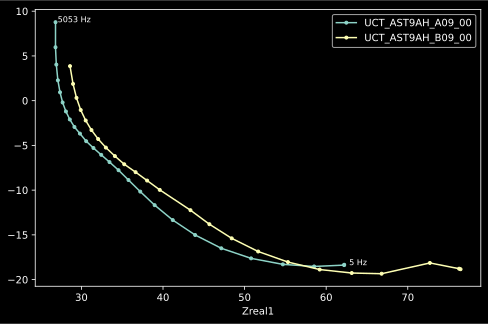

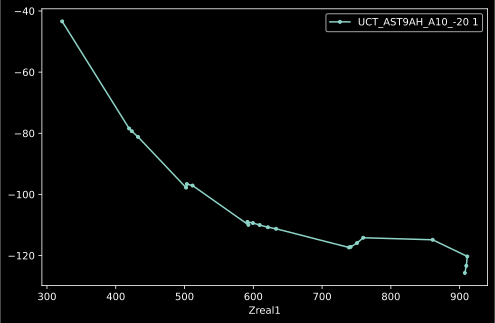

In [13]:
saveDir = "../Plots/EIS/Analysis/SameStateComparison"


def splitEisSameState(
    eisByBattery: Dict[str, EisData]
) -> Dict[str, Dict[str, EisData]]:
    eisByBatteryByTemperature = {}
    for battery in eisByBattery:
        eisByBatteryByTemperature[battery] = splitByTemperature(eisByBattery[battery])
        # Merge RT1 and RT2
        eisByBatteryByTemperature[battery]["RT1"].update(
            eisByBatteryByTemperature[battery]["RT2"]
        )
        del eisByBatteryByTemperature[battery]["RT2"]
        eisByBatteryByTemperature[battery]["RT"] = eisByBatteryByTemperature[
            battery
        ].pop("RT1")

    return eisByBatteryByTemperature


eisSameState = splitEisSameState(eisByBattery)


def plotEisSameStateComparison(
    eisSameState: Dict[str, Dict[str, Dict[str, EisData]]],
):
    with futures.ThreadPoolExecutor() as executor:
        for battery in eisSameState:
            for temperature in eisSameState[battery]:
                if len(eisSameState[battery][temperature]) > 1:
                    soc = getSoC(list(eisSameState[battery][temperature].keys())[0])
                    executor.submit(
                        plotNyquist,
                        eisSameState[battery][temperature],
                        title=f"Same State Comparison Battery {battery} ({soc}) at {temperature}",
                        saveDir=saveDir,
                        fileName=f"{battery}_{temperature}.png",
                        transparent=True,
                        limitFrequencyLabels=True,
                    )


plotEisSameStateComparison(eisSameState)

In [14]:
endTime = time.time()
runTime = endTime - startTime

import duration

print(f"Elapsed runtime: {str(duration.timedelta(seconds=runTime))[2:9]}")

Elapsed runtime: 00:15.3
